## Classification of the CIFAR-10 Dataset

This is a reflective report on the universal deep learning workflow and how it is applied it in the image classification of the CIFAR-10 Dataset.

---

1. Defining the problem and Assembling a Dataset
    - The Problem
    - The Data
    - Naive Baseline
2. Choosing a Measure of Success
    - Primary Metrics
    - Additional Metrics
3. Deciding on an Evaluation Protocol
4. Preparing the Data
    - Preprocessing
    - Post-Processing & Verification
5. Developing and Comparing Two Small Models
    - Model 1 (two hidden 16-unit layers)
    - Model 2 (one hidden 32-unit layer)
    - Comparison & Discussion
6. Scaling up: Overfitting Experiment
    - Model 3 (four dense 128-unit layers)
    - Results & Discussion
7. Regularizing and Hyperparameter Tuning
    - Experiments Setup
    - Experiments results & Discussion
8. Final Model and Test Evaluation
    - Model 4 (Best Hyper-parameters)
    - Results & Discussion

## 1 | Defining the problem and Assembling a Dataset
---
##### The Problem
The CIFAR-10 Consists of 60,000 32x32 color images labeled into 10 classes, with 50,000 for training and 10,000 for testing. Classes include: airplane, car, bird, cat, deer, dog, frog, horse, ship, truck.

Models trained on the CIFAR-10 dataset and other similar datasets have real world applications in object recognization for autonomous systems such as robotics and autonomous driving. The models used in object recognition are critical to the functionality of these systems as a miss-classified or un-recognized object can cause the system to make decisions on false information potentially leading to human harm in both robotics and autonomous driving.

The CIFAR-10 dataset represents a multi-class single label problem, where the objective of the model is to learn intermediate representations of the data that facilitate a single label being assigned per input sample.

##### The Data
The 60,000 samples in the CIFAR-10 dataset are split into 10 classes, encoded as an integer 0-9. We can check the balance of these classes by visualizing the distribution of the number of samples assigned to each class.

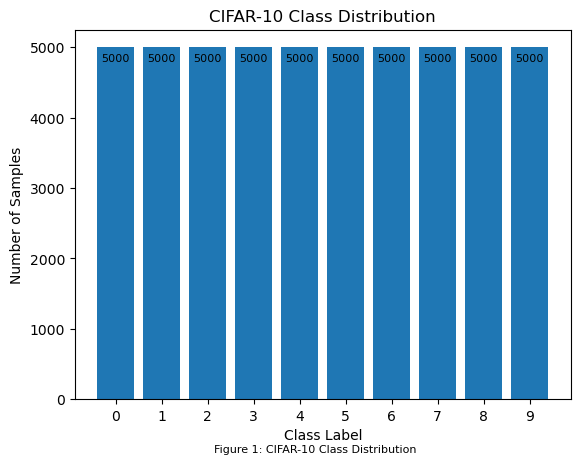

In [33]:
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

# load cifar-10 dataset (if not already loaded)
if 'cifar10' not in globals():
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()

# plot class distribution
classes, counts = np.unique(y_train, return_counts=True)
fig, ax = plt.subplots()
ax.bar(classes, counts)
ax.set_xticks(classes)
ax.set_xticklabels(classes)
ax.set_xlabel('Class Label')
ax.set_ylabel('Number of Samples')
ax.set_title('CIFAR-10 Class Distribution')
# figure text
fig.text(0.5,
         0,
         'Figure 1: CIFAR-10 Class Distribution',
         ha='center',
         fontsize=8)
# add counts on top of bars
for i, count in zip(classes, counts):
    ax.text(i,
            count -200,
            str(count),
            ha='center',
            fontsize=8)
plt.show()

Each class has exactly 5000 samples. This means that the classes are perfectly balanced. Imbalanced classes can lead to a neural network learning intermediate representations that favour one class more than others if that class is favoured in the dataset, or not learning relevent representations at all if a particular class makes up an abnormally small proportion of the data. This would be remidied by oversampling the smaller-sized classes during training, or weighting those samples more during weight change calculation.

